## Data from sediment 
As in previous approaches we didnt reach any good results for niether 3 nor 5 classes classification. In this notebook we will focus on 1 vs many classification to explore classes and find out if we can divide dataset more succesfully.  

In [4]:
#libraries import
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
# for tensorboard logs
import datetime
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_auc_score, roc_curve, accuracy_score
from sklearn.preprocessing import normalize
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split, KFold
from functions import *
from sklearn.preprocessing import LabelEncoder
from keras.callbacks import EarlyStopping

np.random.seed(111)
tf.random.set_seed(111)


In [43]:
df = pd.read_csv('https://raw.githubusercontent.com/paq88/Fish_neural_network_classifier/refs/heads/main/sed_based/Sed/sed_bacteria_full_feature_table.csv')
predictors = df.columns[1:]
print(f"number of predictors/bacteria famillies: {len(predictors)}")
      
# adding collumn with timepoints 
classes = np.tile([0, 1], 25)
df.insert(1,"class_timepoint",  classes)

# replacing NaN values with 0
df.fillna(0, inplace=True)

df.head()




number of predictors/bacteria famillies: 227


,pond,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,Sed_S10,0,111.0,128.0,122.0,101.0,84.0,44.0,42.0,52.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sed_S10,1,18.0,150.0,10.0,129.0,0.0,0.0,30.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Sed_S11,0,81.0,21.0,29.0,90.0,0.0,8.0,10.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Sed_S11,1,3.0,13.0,18.0,3.0,0.0,3.0,18.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Sed_S12,0,171.0,67.0,109.0,76.0,23.0,31.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# for normalisation we will use starndard min-max normalisation
df[predictors] = normalize(df[predictors], norm='max', axis=0, copy=True, return_norm=False)
df.describe()

,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,...,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.500000,0.238804,0.345469,0.125680,0.353059,0.127573,0.167674,0.156283,0.142692,0.223499,...,0.033846,0.022500,0.020000,0.020000,0.030000,0.020000,0.020000,0.020000,0.020000,0.020000
std,0.505076,0.196842,0.256620,0.189293,0.236595,0.211493,0.248427,0.220008,0.221357,0.276172,...,0.170354,0.142163,0.141421,0.141421,0.156818,0.141421,0.141421,0.141421,0.141421,0.141421
min,0.000000,0.000000,0.011719,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.086957,0.134766,0.012645,0.195588,0.000000,0.000000,0.000000,0.000000,0.007019,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.500000,0.222826,0.287109,0.046628,0.332353,0.038835,0.023256,0.053097,0.028846,0.110151,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.343071,0.472656,0.156481,0.470588,0.189320,0.255814,0.247788,0.192308,0.424946,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In this approach we will use 3 class classification based only on water supplementation 
Those classes will be: No supplementation, Em farma, EM

| number | setup | pond numbers | water supplementation | feed supplementation |
|---|---|---|---|---|
|0|control | 8,14,18,24,29|NO|NO|
|1|set 1 | 12,16,19,23,26|Em farma|NO|
|2|set 2 | 10,21,28,30,32|Em farma|EM|
|3|set 3 | 9,13,17,20,27|EM|NO|
|4|set 4 | 11,15,22,25,31|EM|EM|

In [45]:
# function for decoding pond number
def pond_decoder(x,codes):
    
    x=x.replace('S','')
    num = int(x.split("_")[1])
    
    
    for key, value_list in codes.items():
        if num in value_list:
            return key
    
    return None   

In [46]:
# function for reseting model weights
def reset_weights(model):
    for layer in model.layers:
        if hasattr(layer, 'kernel_initializer') and hasattr(layer, 'bias_initializer'):
            layer.kernel.assign(layer.kernel_initializer(tf.shape(layer.kernel)))
            layer.bias.assign(layer.bias_initializer(tf.shape(layer.bias)))


In [47]:
# De coding 

codes5 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26], 2 : [10,21,28,30,32], 3 : [9,13,17,20,27], 4 : [11,15,22,25,31]}

codes3 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32], 2 : [9,13,17,20,27,11,15,22,25,31]}
codes2 = {0 : [8,14,18,24,29], 1: [12,16,19,23,26, 10,21,28,30,32, 9,13,17,20,27,11,15,22,25,31]}
df['pond'] = df['pond'].apply(lambda x: pond_decoder(x,codes2))

In [48]:
pondXtime = df['pond'].astype(str) + "_" + df['class_timepoint'].astype(str)
df.insert(1,"pondXtime", pondXtime)

C:\Users\marek\AppData\Local\Temp\ipykernel_1940\1706034138.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df.insert(1,"pondXtime", pondXtime)


In [49]:
df.head()
df['pondXtime'].value_counts()

pondXtime
1_0    20
1_1    20
0_0     5
0_1     5
Name: count, dtype: int64

As the splitting dataset into train/val and test didnt workout due to probably small number of samples we will stick to only train/val datasets

In [50]:
train_val_df = df.copy()
del(df)

In [51]:
train_val_df['pond'].value_counts()

pond
1    40
0    10
Name: count, dtype: int64

In [36]:
#train_val_df, test_df = train_test_split(df, test_size= 10, random_state=111, stratify=df['pondXtime'])
#print(train_val_df.shape, test_df.shape)

### Functions and definitions

For crossvalidation purposes we will create 5 subsets of size 10 each, 4 of them will be used as train dataset and one as validating dataset.  This then will be repeated 4 times and validation result will be mean of results.

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=111)


In [40]:
# early stopping callback to save the best model weights for test set
es_callback = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=1000,         # Number of epochs with no improvement after which training will be stopped
    verbose=1,           # Verbosity mode
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored quantity
)

Here in one loop we will iterate over all datasets train and validate for each of them and gather results. Using corssvalidation. We will also introduce for debugging purposes, confidence score metric. It is calculated for each predicted label from validation/test dataset. As we probably know output from softmax layer is vector of probabilitis of belonging to each clas 

In [41]:
def crossvalidate(train_val_df, model, predictors, target, kf):
    '''function for crossvalidation of the model
    train_val_df - dataframe with train and validate data
    model - model to be trained
    predictors - list of predictors
    target - target variable
    kf - KFold object
    es_callback - EarlyStopping callback
    '''

    
    i=1

    acc_scores = []
    loss_scores = []

    acc_histories = []
    loss_histories = []
    val_acc_histories = []
    val_loss_histories = []

    global_confidence_scores = []


    for train_index, validate_index in kf.split(train_val_df):
        # reset weights
        reset_weights(model)
        
        train_df = train_val_df.iloc[train_index]
        validate_df = train_val_df.iloc[validate_index]

        # create train and validate datasets 
        X_train = train_df[predictors].values
        y_train = train_df[target].values
        y_train = keras.utils.to_categorical(y_train)

        X_validate = validate_df[predictors].values
        y_validate = validate_df[target].values
        y_validate = keras.utils.to_categorical(y_validate)

        # fit the model
        print(f"training for {i} subset")
        history = model.fit(X_train, y_train, epochs=300, batch_size=5, validation_data=(X_validate, y_validate), verbose=0)
        # evaluate the model

        ev_results = model.evaluate(X_validate, y_validate)



        #save evaluation results 
        acc_scores.append(ev_results[1])
        loss_scores.append(ev_results[0])

        acc_histories.append(history.history['accuracy'])
        loss_histories.append(history.history['loss'])
        val_acc_histories.append(history.history['val_accuracy'])
        val_loss_histories.append(history.history['val_loss'])

        # prediction of the results 
        y_pred = model.predict(X_validate)
        y_pred_class = np.argmax(y_pred, axis=1)
        y_true = np.argmax(y_validate, axis=1)
        print(f"predicted classes:       {y_pred_class}")
        print(f"true validation classes: {y_true}")

        # confidence scores 

        confidence_scores = []
        for row in y_pred:
            highest = np.max(row)
            mean = np.mean(np.delete(row, np.argmax(row)))
            confidence_score = round(((highest / mean)-1),4)
            confidence_scores.append(confidence_score)
            global_confidence_scores.append(confidence_score)
        
        mean_confidence = np.mean(confidence_scores)
        sd_confidence = np.std(confidence_scores)

        print(f"mean confidence score: {round(mean_confidence,4)}, sd confidence score: {round(sd_confidence,4)}")
        print("=====================================================")

        



        i+=1

    # calculate mean scores

    mean_acc_score = np.mean(acc_scores)
    sd_acc_score = np.std(acc_scores)
    mean_loss_score = np.mean(loss_scores)
    sd_loss_score = np.std(loss_scores)


    # part to plot mean values from history
    
    # mean and sd values for learning curves 
    mean_acc_histories = np.nanmean(acc_histories, axis=0)
    sd_acc_histories = np.nanstd(acc_histories, axis=0)
    mean_val_acc_histories = np.nanmean(val_acc_histories, axis=0)
    sd_val_acc_histories = np.nanstd(val_acc_histories, axis=0)
    mean_loss_histories = np.nanmean(loss_histories, axis=0)
    sd_loss_histories = np.nanstd(loss_histories, axis=0)
    mean_val_loss_histories = np.nanmean(val_loss_histories, axis=0)
    sd_val_loss_histories = np.nanstd(val_loss_histories, axis=0)
    

    print(f"validation set mean accuracy: {round(mean_acc_score,4)}, sd{round(sd_acc_score,4)}, mean loss: {round(mean_loss_score,4)}, sd: {round(sd_loss_score,4)}")
    print(f"global mean confidence score: {round(np.mean(global_confidence_scores),4)}, sd confidence score: {round(np.std(global_confidence_scores),4)}")
    # plotting mean curves 

    plt.figure(figsize=(15, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(mean_acc_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_acc_histories)), mean_acc_histories - sd_acc_histories, mean_acc_histories + sd_acc_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_acc_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_acc_histories)), mean_val_acc_histories - sd_val_acc_histories, mean_val_acc_histories + sd_val_acc_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Accuracy")

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(mean_loss_histories, label='train', color='blue')
    plt.fill_between(range(len(mean_loss_histories)), mean_loss_histories - sd_loss_histories, mean_loss_histories + sd_loss_histories, color='blue', alpha=0.2)
    plt.plot(mean_val_loss_histories, label='validate', color='orange')
    plt.fill_between(range(len(mean_val_loss_histories)), mean_val_loss_histories - sd_val_loss_histories, mean_val_loss_histories + sd_val_loss_histories, color='orange', alpha=0.2)
    plt.legend()
    plt.title("Mean Loss")

    plt.show()


    # calculating min and max values for loss plots range 
    flat_loss_histories = np.concatenate(loss_histories)
    flat_val_loss_histories = np.concatenate(val_loss_histories)
    min_loss = min((min(flat_loss_histories), min(flat_val_loss_histories)))
    max_loss = max((max(flat_loss_histories), max(flat_val_loss_histories)))



    # Plotting results for each fold 
    fig, axs = plt.subplots(2, 2, figsize=(15, 10))


    # Accuracy
    for i, acc in enumerate(acc_histories):
        axs[0, 0].plot(acc, label=f'Fold {i+1}')
    axs[0, 0].set_title('Training Accuracy')
    axs[0, 0].set_xlabel('Epochs')
    axs[0, 0].set_ylabel('Accuracy')
    axs[0, 0].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 0].legend()

    # Validation Accuracy
    for i, val_acc in enumerate(val_acc_histories):
        axs[0, 1].plot(val_acc, label=f'Fold {i+1}')
    axs[0, 1].set_title('Validation Accuracy')
    axs[0, 1].set_xlabel('Epochs')
    axs[0, 1].set_ylabel('Accuracy')
    axs[0, 1].set_ylim(0, 1)  # Set y-axis scale from 0 to 1
    axs[0, 1].legend()

    # Loss
    for i, loss in enumerate(loss_histories):
        axs[1, 0].plot(loss, label=f'Fold {i+1}')
    axs[1, 0].set_title('Training Loss')
    axs[1, 0].set_xlabel('Epochs')
    axs[1, 0].set_ylabel('Loss')
    axs[1, 0].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum loss value
    axs[1, 0].legend()

    # Validation Loss
    for i, val_loss in enumerate(val_loss_histories):
        axs[1, 1].plot(val_loss, label=f'Fold {i+1}')
    axs[1, 1].set_title('Validation Loss')
    axs[1, 1].set_xlabel('Epochs')
    axs[1, 1].set_ylabel('Loss')
    axs[1, 1].set_ylim(min_loss,max_loss)  # Set y-axis scale based on the maximum validation loss value
    axs[1, 1].legend()

    plt.tight_layout()
    plt.show()




## Modelling 
We will perform 1 vs many classificaiton, There will be big overepresentation of many and we can expect the model to just classify everything to class "many" as this will give the best results on paper. Most biological sense makes to try controll vs many so thats where we will start thats why we will not test that extensively. 

### Modelling controll vs rest

In [42]:
model1 = keras.Sequential()



model1.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(64, activation ='relu'))
model1.add(keras.layers.Dense(16, activation ='relu'))
model1.add(keras.layers.Dropout(rate=0.25))
model1.add(keras.layers.Dense(16, activation ='relu'))

model1.add(keras.layers.Dense(2, activation ='softmax'))

print(model1.summary())


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model1.compile(optimizer = optimizer, loss = loss, metrics=metrics)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                 │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,786 (151.51 KB)

 Trainable params: 38,786 (151.51 KB)

 Non-trainable params: 0 (0.00 B)

None


training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.6000 - loss: 3.3128
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
predicted classes:       [1 1 1 1 1 1 1 1 1 1]
true validation classes: [1 0 0 0 1 1 1 1 1 0]
mean confidence score: 436630.4046, sd confidence score: 1193941.1225
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6000 - loss: 3.2202
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
predicted classes:       [0 1 1 1 0 1 1 1 1 1]
true validation classes: [1 1 0 1 1 1 1 0 1 1]
mean confidence score: 8251465.8387, sd confidence score: 17701749.0546
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.9000 - loss: 0.6134
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 1 1 1 1 1 1 1 1 1]
true validation classes: [1 1 0 1 1 1 1 1 1 1]
mean confidence score: 230915447.8605, sd confidence score: 692698669.4045
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.8000 - loss: 1.8876
1/1 ━━━━━━

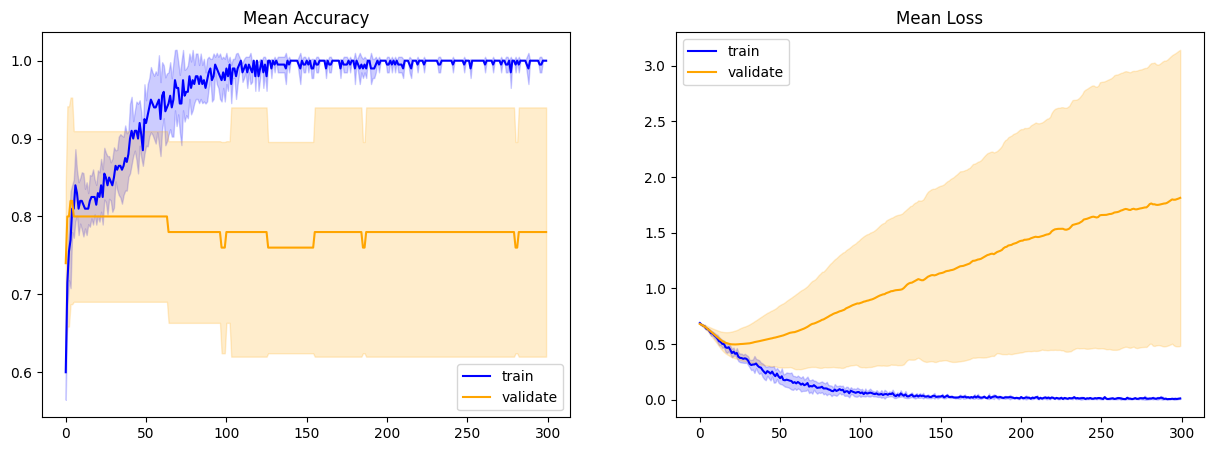

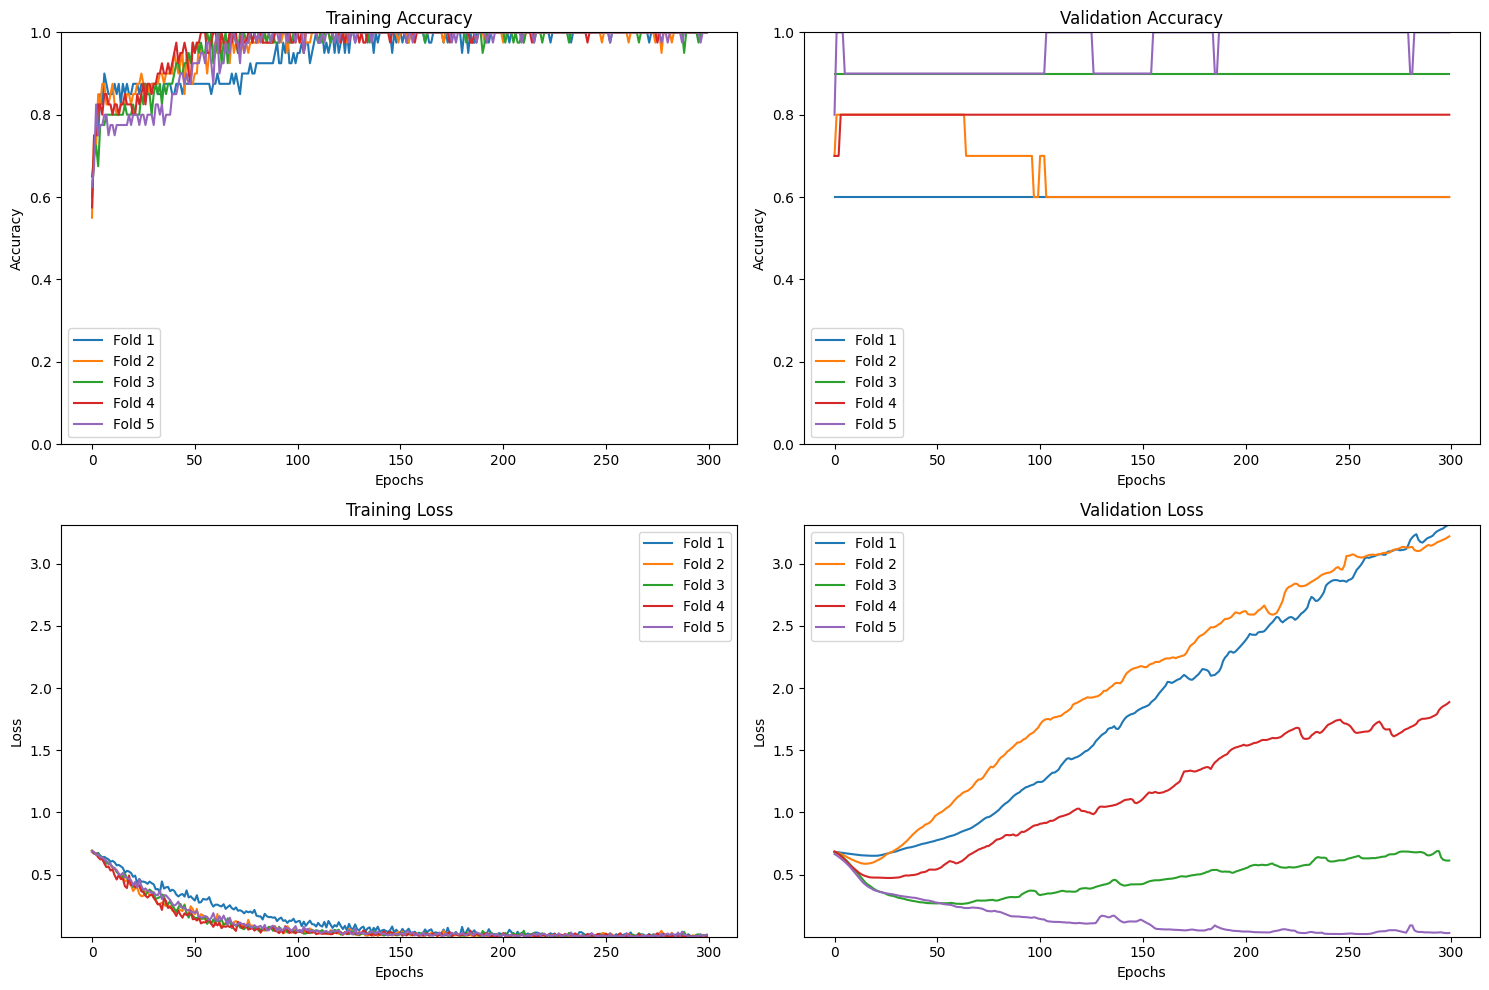

In [52]:
crossvalidate(train_val_df, model1, predictors, 'pond', kf)

As we suspected because of overrepresentaion model is classifying everything to class 1 (many), and is pretty sure of its decisions with very high confidence sscore. We can fight this by oversampling our controll class.

#### Oversampling controll
ref: 
Learning from Imbalanced Data
Haibo He, Member, IEEE, and Edwardo A. Garcia 
https://sci-hub.st/10.1109/tkde.2008.239
https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/

For oversampling we will use SMOTE algorythm as it is more sophisticated than just duplicating.

In [55]:
from imblearn.over_sampling import SMOTE

In [61]:
smote = SMOTE(random_state=111)
X = train_val_df[predictors].values
y = train_val_df['pond']
X_smote, y_smote = smote.fit_resample(X, y)
 

In [62]:
print(X.shape, y.shape)
print(X_smote.shape, y_smote.shape)

(50, 227) (50,)
(80, 227) (80,)


In [66]:
df_smote = pd.concat([pd.DataFrame(X_smote, columns=predictors), pd.DataFrame(y_smote, columns=['pond'])], axis=1)


,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,d__Bacteria;p__Actinobacteriota;c__Thermoleophilia;o__Solirubrobacterales;f__67-14,d__Bacteria;p__Cyanobacteria;c__Cyanobacteriia;o__Cyanobacteriales;f__Phormidiaceae,d__Bacteria;p__Desulfobacterota;c__Syntrophia;o__Syntrophales;f__uncultured,...,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19,pond
0,0.301630,0.500000,0.064278,0.594118,0.815534,0.511628,0.371681,1.000000,0.518359,0.438462,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
1,0.048913,0.585938,0.005269,0.758824,0.000000,0.000000,0.265487,0.615385,0.030238,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
2,0.220109,0.082031,0.015279,0.529412,0.000000,0.093023,0.088496,0.000000,0.077754,0.461538,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
3,0.008152,0.050781,0.009484,0.017647,0.000000,0.034884,0.159292,0.000000,0.000000,0.323077,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
4,0.464674,0.261719,0.057429,0.447059,0.223301,0.360465,0.000000,0.019231,0.760259,0.376923,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,0.117316,0.093952,0.100837,0.221957,0.085956,0.000000,0.127785,0.042938,0.404129,0.198210,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
76,0.120977,0.063878,0.145002,0.353660,0.172330,0.000000,0.016765,0.000000,0.607200,0.204017,...,0.052778,0.052778,0.052778,0.026389,0.052778,0.052778,0.052778,0.052778,0.0,0
77,0.262171,0.173932,0.060521,0.562891,0.205462,0.039701,0.158858,0.006253,0.565189,0.388616,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0
78,0.424063,0.701579,0.133643,0.284136,0.205228,0.397459,0.291381,0.062603,0.622226,0.534662,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0


#### Modeling oversampled dataset

In [70]:
model2 = keras.Sequential()



model2.add(keras.layers.Dense(128,input_shape=(len(predictors),),activation='relu'))


model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(64, activation ='sigmoid'))
model2.add(keras.layers.Dropout(rate=0.25))
model2.add(keras.layers.Dense(16, activation ='sigmoid'))

model2.add(keras.layers.Dense(2, activation ='softmax'))

model2.summary()

loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model2.compile(optimizer = optimizer, loss = loss, metrics=metrics)

C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 128)            │        29,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 2)              │            34 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,514 (150.45 KB)

 Trainable params: 38,514 (150.45 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 1.0000 - loss: 0.0478
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
predicted classes:       [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
true validation classes: [1 1 0 1 1 1 1 1 1 0 1 0 0 0 0 0]
mean confidence score: 50.2534, sd confidence score: 33.8557
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9375 - loss: 0.1785
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
true validation classes: [1 1 1 0 1 1 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 78.5066, sd confidence score: 44.678
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.9375 - loss: 0.2109
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0]
true validation classes: [0 1 0 0 1 0 1 1 0 0 0 0 0 0 0 0]
mean confidence score: 86.7921, sd confidence score: 38.8536
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accura

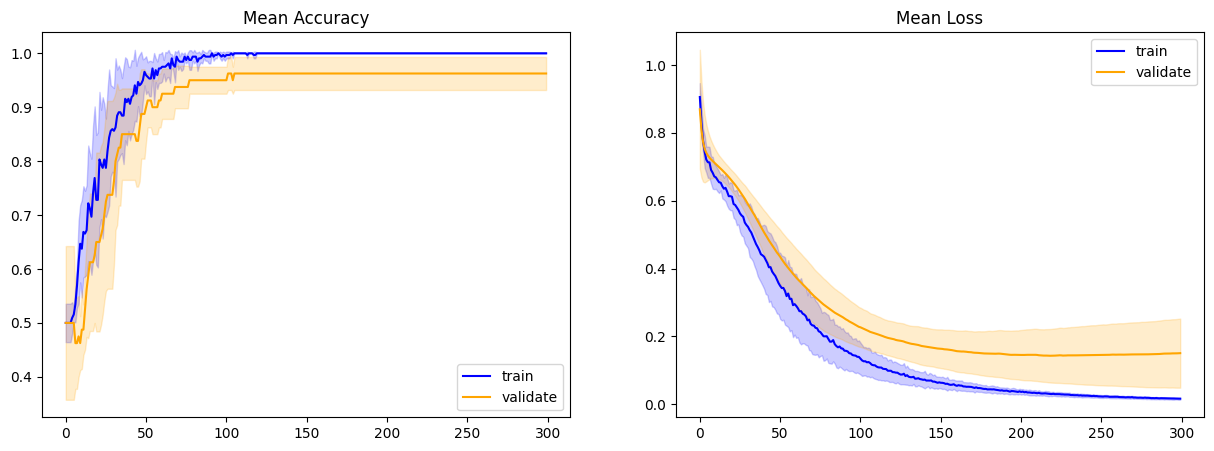

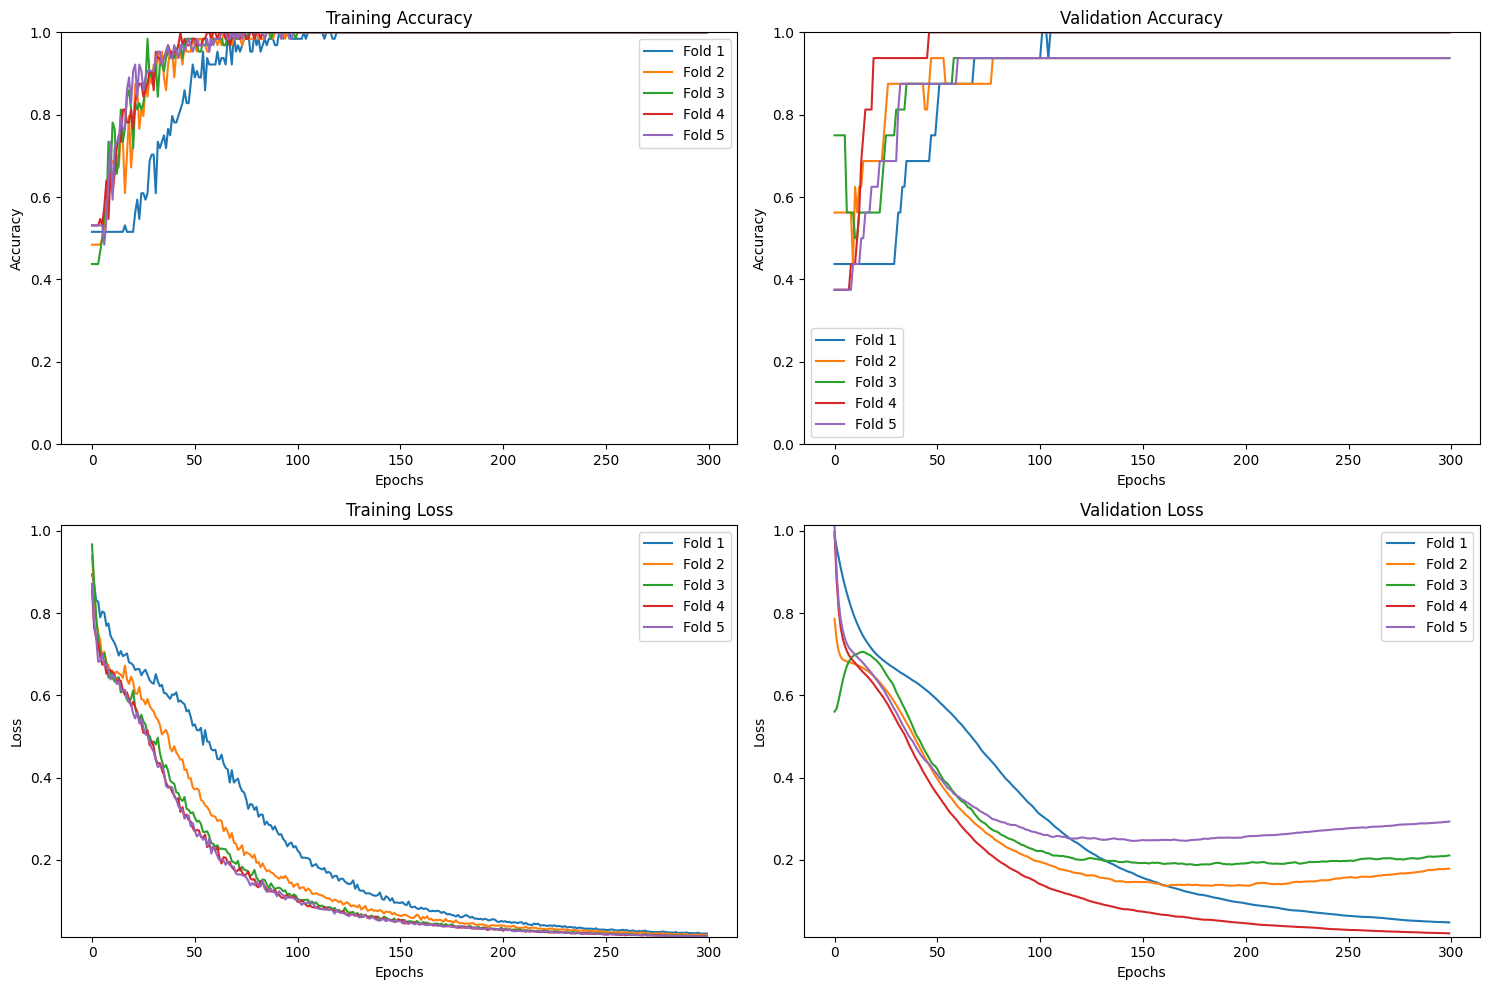

In [71]:
crossvalidate(df_smote, model2, predictors, 'pond', kf)

After oversampling we can see some interestingly good results, with mean validation accuracy over 0.96 it looks like there are significant enough differences between controll and supplemented setups for model to detect.

XXXXXXXXx

In [46]:
df_first_tp = train_val_df[train_val_df["class_timepoint"]==0]
print(df_first_tp.shape)
df_first_tp.head()

(25, 230)


,pond,pondXtime,class_timepoint,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Sutterellaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Comamonadaceae,d__Bacteria;p__Proteobacteria;c__Gammaproteobacteria;o__Burkholderiales;f__Rhodocyclaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Sphingobacteriales;f__Lentimicrobiaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfobulbaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Chitinophagales;f__Saprospiraceae,d__Bacteria;p__Firmicutes;c__Bacilli;o__Bacillales;f__Bacillaceae,...,d__Bacteria;p__Desulfobacterota;c__Desulfobacteria;o__Desulfobacterales;f__Desulfobacterales,d__Bacteria;p__Campilobacterota;c__Campylobacteria;o__Campylobacterales;f__Sulfurimonadaceae,d__Bacteria;p__Desulfobacterota;c__Desulfobulbia;o__Desulfobulbales;f__Desulfurivibrionaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;__,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Marinilabiliaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Rs-E47_termite_group,d__Bacteria;p__Chloroflexi;c__Dehalococcoidia;o__Dehalococcoidales;f__uncultured,d__Bacteria;p__Firmicutes;c__Bacilli;o__Erysipelotrichales;f__Erysipelatoclostridiaceae,d__Bacteria;p__Bacteroidota;c__Bacteroidia;o__Bacteroidales;f__Barnesiellaceae,d__Bacteria;p__Myxococcota;c__Polyangia;o__Blfdi19;f__Blfdi19
0,1,1_0,0,0.301630,0.500000,0.064278,0.594118,0.815534,0.511628,0.371681,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,2_0,0,0.220109,0.082031,0.015279,0.529412,0.000000,0.093023,0.088496,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1,1_0,0,0.464674,0.261719,0.057429,0.447059,0.223301,0.360465,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2,2_0,0,0.173913,0.722656,0.000000,0.435294,0.106796,0.220930,0.530973,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0,0_0,0,0.095109,0.269531,0.007903,0.017647,0.000000,0.000000,0.362832,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [47]:
model4 = keras.Sequential()



model4.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(64, activation ='relu'))
model4.add(keras.layers.Dropout(rate=0.25))
model4.add(keras.layers.Dense(16, activation ='relu'))

model4.add(keras.layers.Dense(3, activation ='softmax'))

model4.summary()


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model4.compile(optimizer = optimizer, loss = loss, metrics=metrics)



C:\Users\marek\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_13 (Dense)                │ (None, 256)            │        58,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 16)             │         1,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,907 (296.51 KB)

 Trainable params: 75,907 (296.51 KB)

 Non-trainable params: 0 (0.00 B)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.4000 - loss: 2.0729
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
predicted classes:       [1 2 1 2 2]
true validation classes: [2 0 1 0 2]
mean confidence score: 24.0663, sd confidence score: 43.6755
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 2.0909
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [1 2 0 0 2]
true validation classes: [2 1 1 2 1]
mean confidence score: 13.1765, sd confidence score: 23.9809
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4000 - loss: 0.9984
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
predicted classes:       [2 2 1 1 2]
true validation classes: [1 2 2 1 0]
mean confidence score: 73.8616, sd confidence score: 142.5898
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2000 - loss: 2.3334
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
predicted classes:       [2 1 1 2 2]
true validation classes:

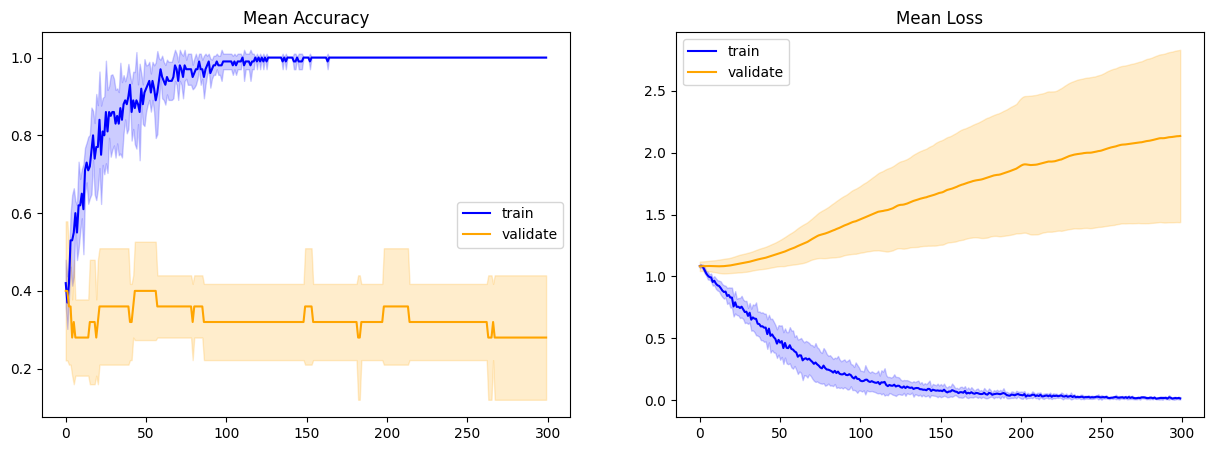

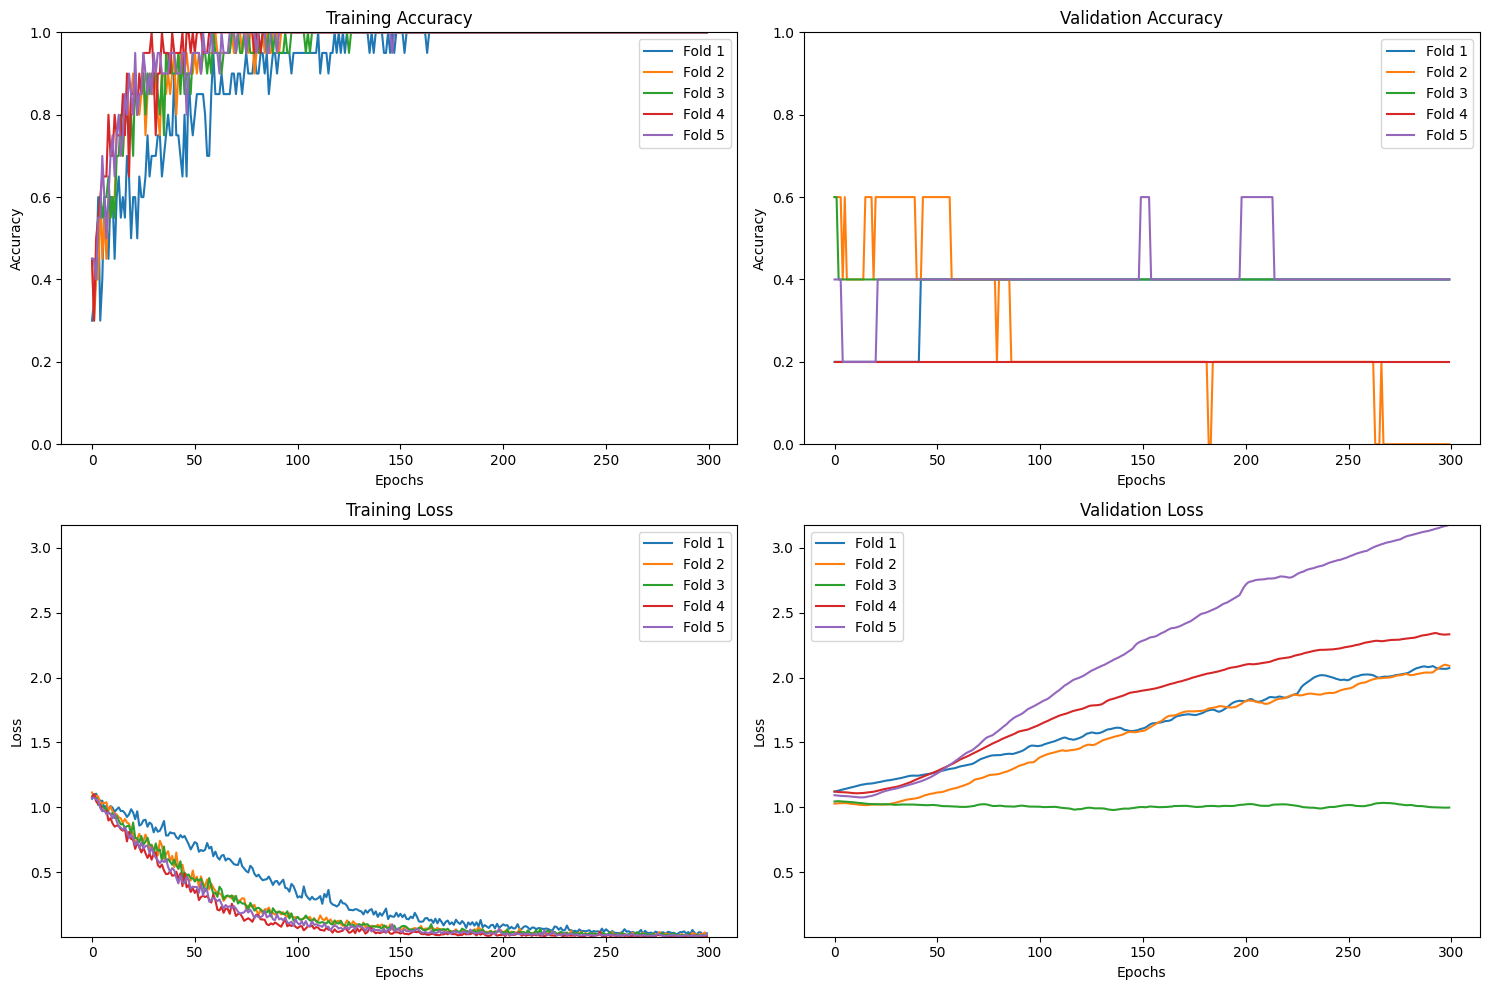

In [48]:
crossvalidate(df_first_tp, model4, predictors, 'pond', kf)

The results for 1'st timepoint are also not great to say the least. We will go on and check last option which is 6 class (time*class) to get all 50 samples for analysys.

### Modeling 6 classes for 2 timepoints

In [49]:
model5 = keras.Sequential()



model5.add(keras.layers.Dense(256,input_shape=(len(predictors),),activation='relu'))


model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(64, activation ='relu'))
model5.add(keras.layers.Dropout(rate=0.25))
model5.add(keras.layers.Dense(16, activation ='relu'))

model5.add(keras.layers.Dense(6, activation ='softmax'))


loss = "categorical_crossentropy"
#metrics = "sparse_categorical_crossentropy"
metrics = ["accuracy"]

optimizer = keras.optimizers.Adam(learning_rate = 0.0001)

model5.compile(optimizer = optimizer, loss = loss, metrics=metrics)

In [50]:
train_val_df['pondXtime_encoded'] = LabelEncoder().fit_transform(train_val_df['pondXtime'])
train_val_df['pondXtime_encoded'] = train_val_df['pondXtime_encoded'].astype(int)

training for 1 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1000 - loss: 3.5223
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
predicted classes:       [3 5 2 3 4 3 5 2 3 5]
true validation classes: [2 0 1 1 4 5 3 4 5 0]
mean confidence score: 10.7395, sd confidence score: 11.2332
training for 2 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1000 - loss: 4.3002
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
predicted classes:       [1 2 4 2 2 2 3 3 3 3]
true validation classes: [5 2 1 5 5 3 2 0 5 4]
mean confidence score: 8.0695, sd confidence score: 5.8655
training for 3 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1000 - loss: 4.0977
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
predicted classes:       [4 4 4 4 4 3 4 3 5 4]
true validation classes: [3 4 0 3 5 2 3 2 3 3]
mean confidence score: 2668.7213, sd confidence score: 7949.2991
training for 4 subset
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1000 - loss: 3.5204
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
pred

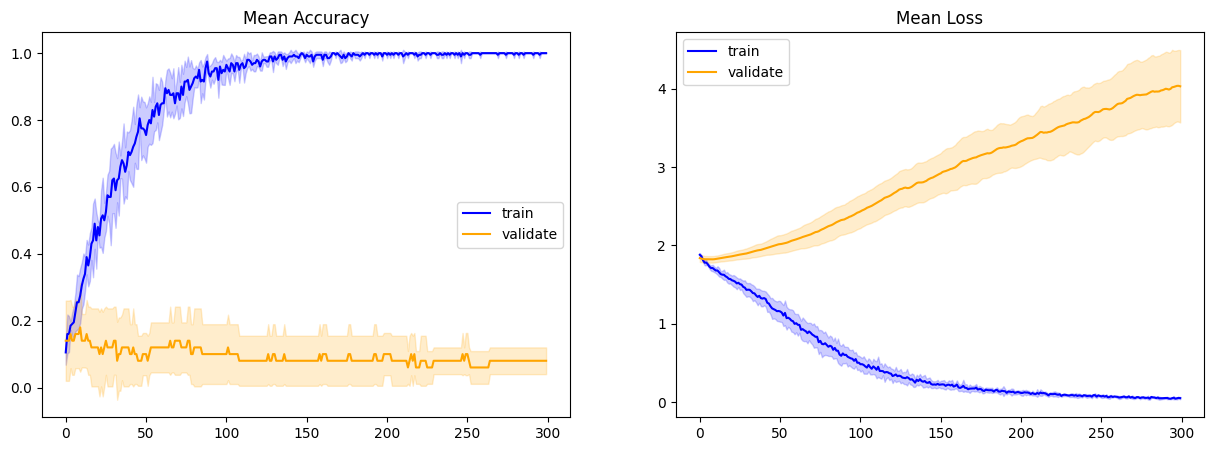

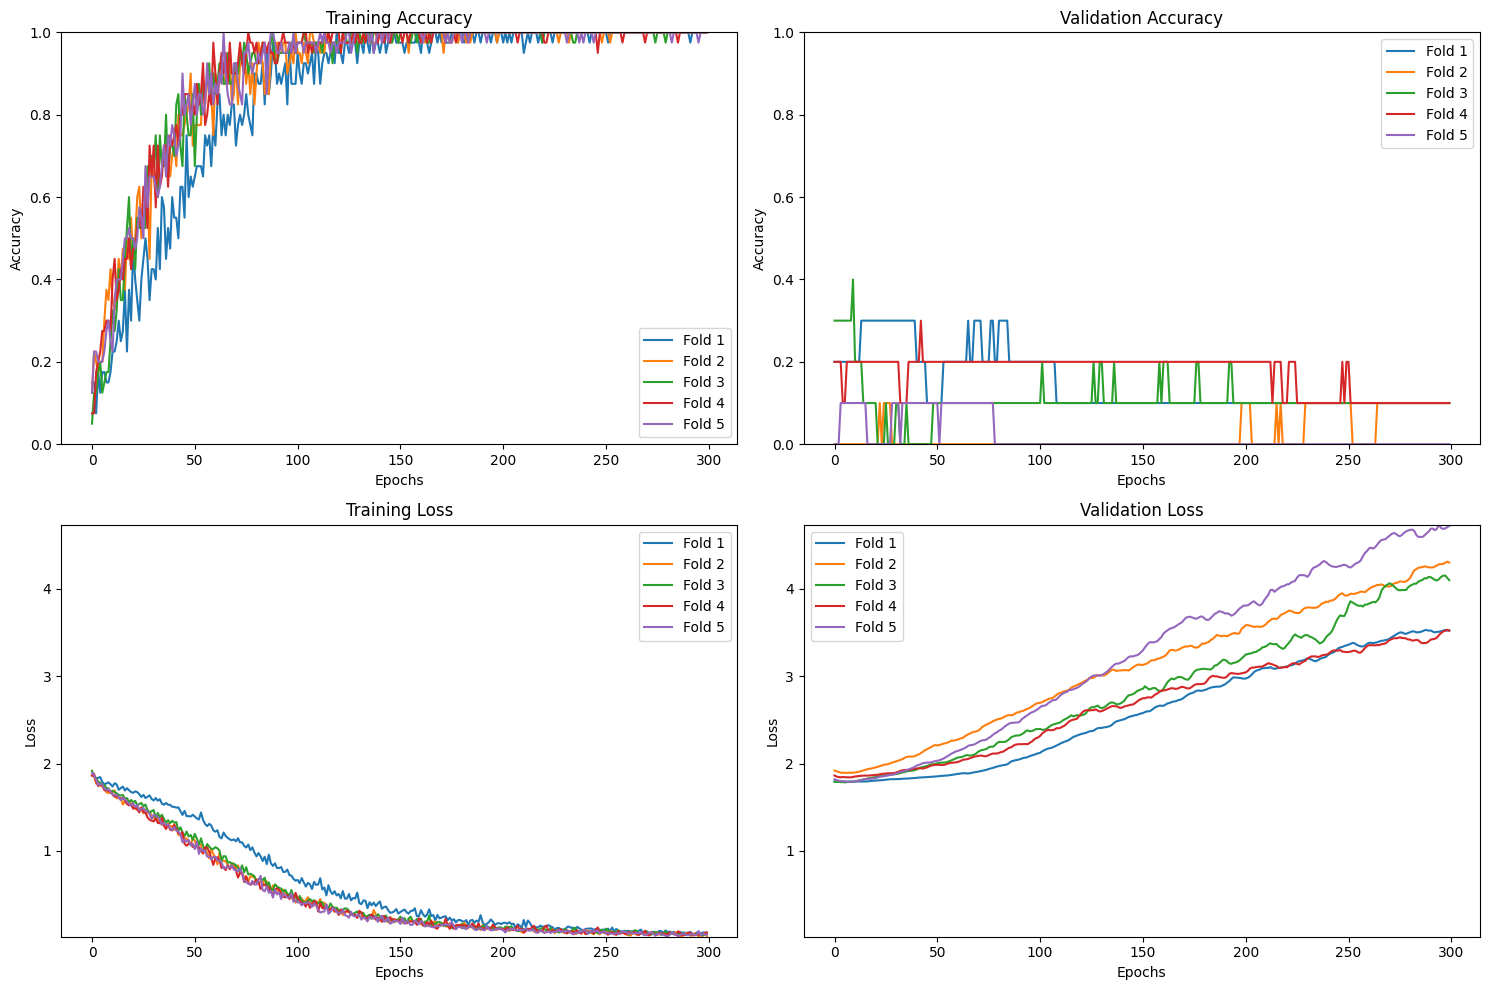

In [51]:
crossvalidate(train_val_df, model5, predictors, 'pondXtime_encoded', kf)

Classification for 6 classes didn't help either, as we didnt really improve class to samples ratio.

 ### Conclusions
 In conclusion for all the modeling above we can say that 
1. The results were quite similar
2. mean validation accuracy didnt reach above 0.3 threshold wchich for 3 classes is worse than random choices. It is hard to say whenever the cause for that is too little samples or not enough differences but as we didnt have much better results for 5 classes i think 3 classes are better approach. 
3. The confidecnce score for all the models were quite high and loss curves for training were quite low, that indicates that model was learning and was "sure of it's decisions" This means that probable cause for low validation accuracy is low number of samples and overfitting caused by that. If there were no differences between classes confidence score should be lower. 
4. After changing activation functions from standard relu to sigmoid we can observe that the learning curves are much more chaotic. But accuracy is better. 

We will now check that by doing class exploration by performing one vs many classification for each class of  and seeing the results. This will be done in next notebook.